In [10]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import *
from sklearn.decomposition import *
from sklearn.metrics import *
import torch
from torch import nn
from torch.utils.data import *
from torchvision import datasets
from torchvision.transforms import *


In [11]:


root_results_dir = "/Users/newuser/Projects/robust-algo-trader/data/trades_seq_fixed_EURUSD_H1_2011_2023.csv"
df = pd.read_csv(f"{root_results_dir}")

y = df["label"]
X = df.drop(columns=["index", "ask_price", "take_profit_price",
                     "MACD", "MACD_Signal", "MACD_Hist",
            "stop_loss_price", "SMA_200", "Date_Time", "label"])


In [12]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_train = torch.tensor(X_train.values.astype(np.float32))
X_test = torch.tensor(X_test.values.astype(np.float32))
y_train = torch.tensor(y_train.values.astype(np.int64))
y_test = torch.tensor(y_test.values.astype(np.int64))

batch_size = 64

# Create DataLoader objects for training and testing
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)




In [13]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_size),
            nn.ReLU(),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


# Define the custom loss function
class PrecisionLoss(nn.Module):
    def __init__(self, alpha=1.0):
        super(PrecisionLoss, self).__init__()
        self.alpha = alpha  # Adjust this parameter to control the emphasis on precision

    def forward(self, predicted, target):
        # Calculate precision
        true_positives = (predicted * target).sum(dim=0)
        false_positives = (predicted * (1 - target)).sum(dim=0)

        precision = true_positives / (true_positives + self.alpha * false_positives + 1e-9)

        # Use negative precision as the loss to maximize precision during training
        loss = -precision.mean()

        return loss
    
input_size = len(X.columns)
hidden_size = 64
output_size = 1
model = NeuralNetwork(input_size, hidden_size, output_size).to(device)
loss_fn = PrecisionLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
print(model)

Using mps device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=14, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
    (5): ReLU()
    (6): Sigmoid()
  )
)


In [14]:

# Define train function
def train(dataloader, model, criterion, optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        X, y = X.to(device), y.to(device)
        pred = model(X)
        label = y.float().view(-1, 1)
        loss = criterion(pred, label)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        correct += (pred > 0.5).eq(y.view_as(pred)).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Train Loss: \n {loss:>7f}[{current:>5d}/{size:>5d}]")
        mean_accuracy = 100.0 * (correct / size)
        return mean_accuracy

# Define test function
def test(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            label = y.float().view(-1, 1)
            test_loss += criterion(pred,label).item()
            # accuracy += ((pred > 0.5).eq(y).type(torch.float).sum().item())
            # accuracy += ((pred > 0.5).eq(y).type(torch.float).mean().item())
            correct += (pred > 0.5).eq(y.view_as(pred)).sum().item()
    test_loss /= num_batches
    # correct /= size
    mean_accuracy = 100.0 * (correct / size)
    print(f"Test Error: \n Accuracy: {(mean_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return mean_accuracy

# # Train and test the model
# epochs = 20
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train(train_dataloader, model, loss_fn, optimizer)
#     test(test_dataloader, model, loss_fn)
# print("Done!")

Epoch 1
-------------------------------
Train Loss: 
 -0.406977[   64/ 2069]
Test Error: 
 Accuracy: 54.3%, Avg loss: -0.417594 

Epoch 2
-------------------------------
Train Loss: 
 -0.365854[   64/ 2069]
Test Error: 
 Accuracy: 54.3%, Avg loss: -0.417636 

Epoch 3
-------------------------------
Train Loss: 
 -0.349398[   64/ 2069]
Test Error: 
 Accuracy: 54.3%, Avg loss: -0.417659 

Epoch 4
-------------------------------
Train Loss: 
 -0.380952[   64/ 2069]
Test Error: 
 Accuracy: 54.3%, Avg loss: -0.416757 

Epoch 5
-------------------------------
Train Loss: 
 -0.461538[   64/ 2069]
Test Error: 
 Accuracy: 54.3%, Avg loss: -0.413697 

Epoch 6
-------------------------------
Train Loss: 
 -0.530120[   64/ 2069]
Test Error: 
 Accuracy: 54.3%, Avg loss: -0.418514 

Epoch 7
-------------------------------
Train Loss: 
 -0.425287[   64/ 2069]
Test Error: 
 Accuracy: 54.3%, Avg loss: -0.419909 

Epoch 8
-------------------------------
Train Loss: 
 -0.452381[   64/ 2069]
Test Error: 


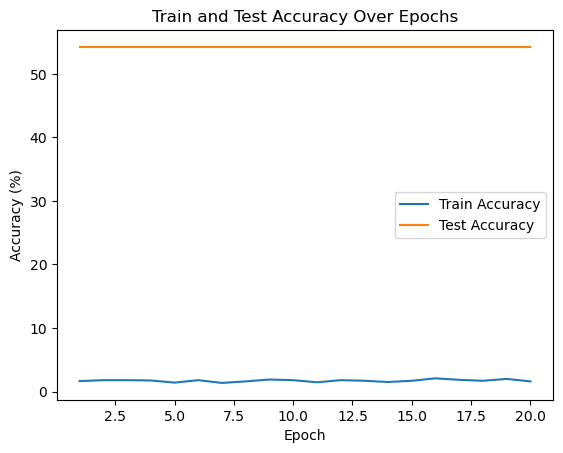

In [15]:
import matplotlib.pyplot as plt

# Assuming you have a list to store train and test accuracies for each epoch
train_accuracies = []
test_accuracies = []

# Your training loop with accuracy calculations during each epoch
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_acc = train(train_dataloader, model, loss_fn, optimizer)
    test_acc = test(test_dataloader, model, loss_fn)
    
    # Append accuracies to the lists
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plot the graph
epochs_range = range(1, epochs+1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracy Over Epochs')
plt.legend()
plt.show()



In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')